# determine the cuts to NASA-Sloan Atlas observations
The cuts aim to do two things:
1. Only keep objects that we know are galaxies
2. Only keep galaxies that are accurately modeled by the simulation (TNG + SED modeling)

For 1., we'll impose cuts on photometric uncertainties in order to only keep galaxies with reliable photometry.

For 2., we'd ideally want to select galaxies (through color cuts or other observables) based on how much we trust the simulations. In practice, this is complicated and beyond the scope of this "proof-of-concept" work. Instead we'll use color and magnitudes cuts to only analyze galaxies that are well within the color distribution of the simulated galaxies.

In [1]:
import os
import h5py 
import numpy as np

In [2]:
from astropy.table import Table

In [3]:
import corner as DFM
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
dat_dir = '/tigress/chhahn/goleta/'

nsa = Table.read(os.path.join(dat_dir, 'nsa_v0_1_2.fits'))
absmag_nsa = np.array(nsa['ABSMAG'].data)[:,3:] # g, r, i, z
ivar_absmag_nsa = np.array(nsa['AMIVAR'].data)[:,3:]

cuts = (nsa['Z'] < 0.05)

In [5]:
mag_sig = np.concatenate([absmag_nsa, ivar_absmag_nsa**-0.5], axis=1)
mag_sig = mag_sig[np.all(np.isfinite(mag_sig), axis=1) & cuts]

/home/chhahn/.conda/envs/sbi/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in power
  """Entry point for launching an IPython kernel.


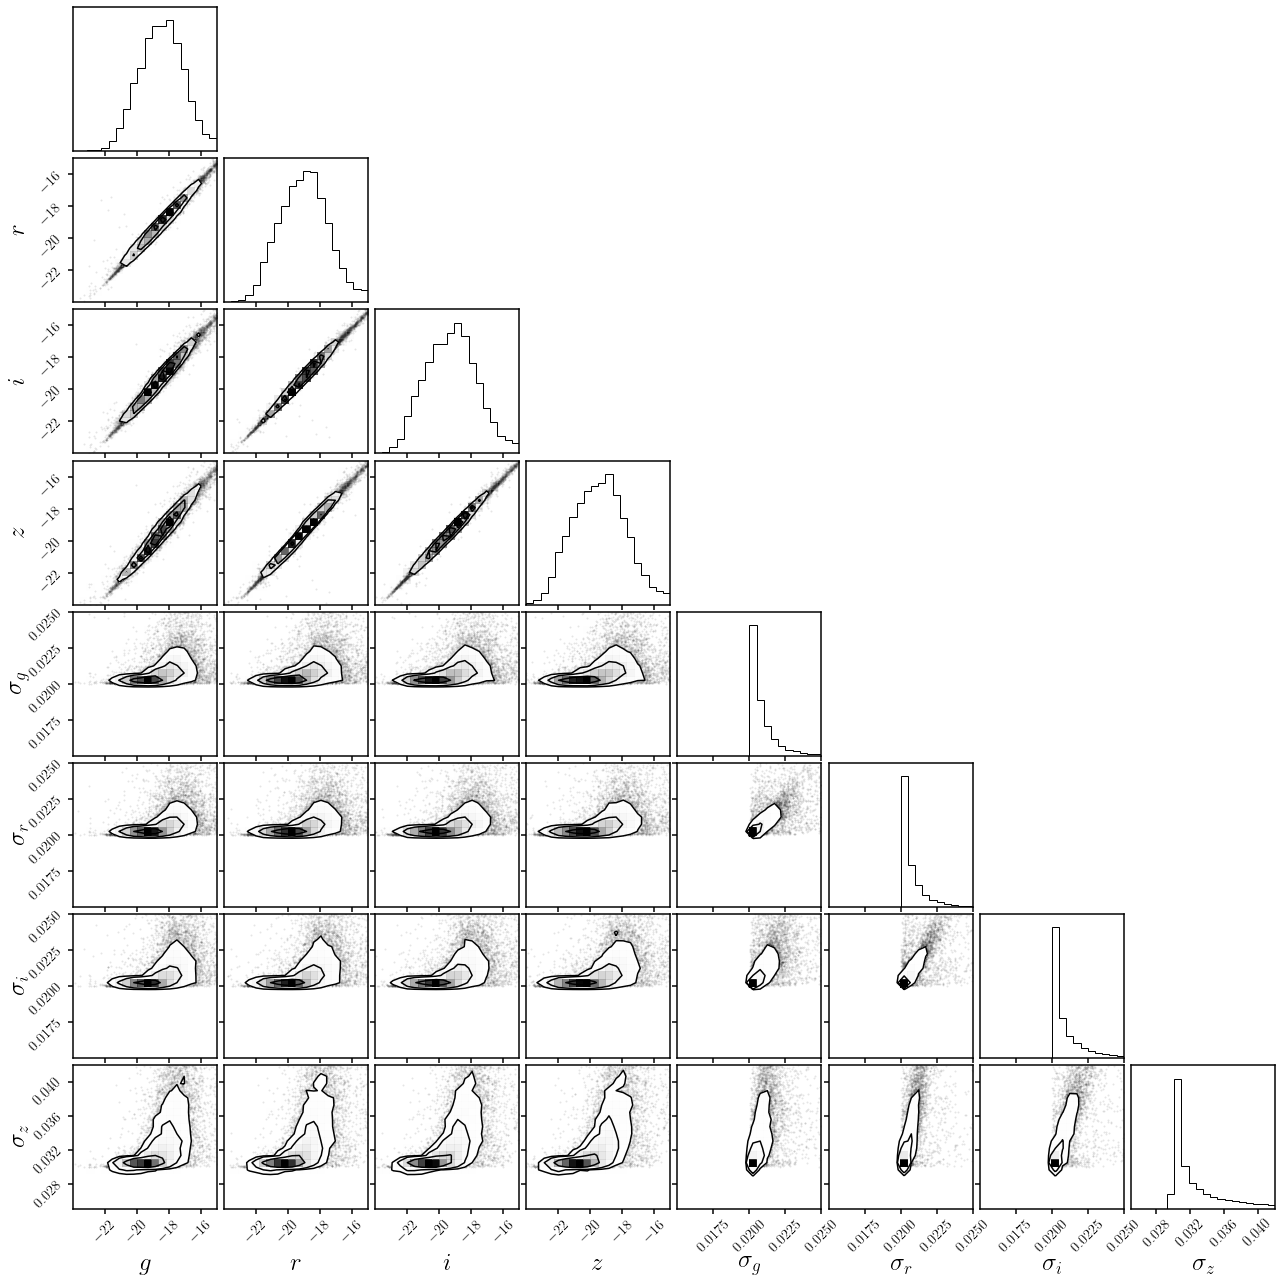

In [6]:
fig = DFM.corner(mag_sig[::10], color='k', hist_kwargs={'density': True},
               range=[(-24, -15), (-24, -15), (-24, -15), (-24, -15), 
                      (0.015, 0.025), (0.015, 0.025), (0.015, 0.025), (0.025, 0.042)],
               labels=[r'$%s$' % b for b in ['g', 'r', 'i', 'z']] + [r'$\sigma_g$', r'$\sigma_r$', r'$\sigma_i$', r'$\sigma_z$'],
               label_kwargs={'fontsize': 25})

# 1. photometric uncertainty cuts
to only select objects with reliable photometry

0.020000303 0.022029992192983627


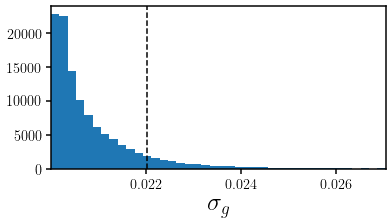

0.020000089 0.02179212510585785


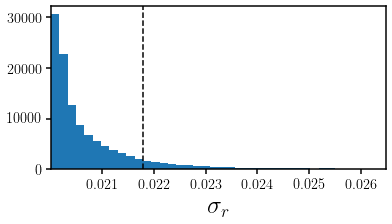

0.02000019 0.02279640145599842


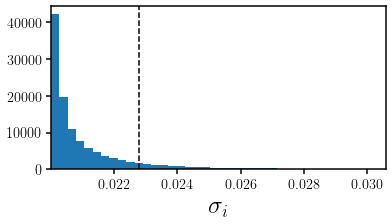

0.030000037 0.0443125319480896


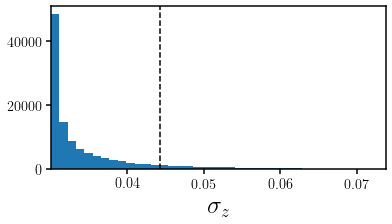

In [7]:
for i in range(4): 
    print(mag_sig[:,i+4].min(), np.quantile(mag_sig[:,i+4], 0.84))

    fig = plt.figure(figsize=(6,3))
    sub = fig.add_subplot(111)
    _ = sub.hist(mag_sig[:,i+4], range=np.quantile(mag_sig[:,i+4], (0.0, 0.95)), bins=40)
    
    sub.axvline(np.quantile(mag_sig[:,i+4], (0.84)), color='k', linestyle='--')            
    sub.set_xlabel('$\sigma_{%s}$' % (['g', 'r', 'i', 'z'][i]), fontsize=25)
    sub.set_xlim(mag_sig[:,i+4].min(), np.quantile(mag_sig[:,i+4], (0.95)))
    plt.show()

based on these distributions, we'll impose the following cuts: 

$$0.02 < \sigma_g < 0.022$$
$$0.02 < \sigma_r < 0.022$$
$$0.02 < \sigma_i < 0.022$$
$$0.03 < \sigma_z < 0.04$$

In [8]:
sig_cuts = (
    (mag_sig[:,4] > 0.02) & (mag_sig[:,4] < 0.022) &
    (mag_sig[:,5] > 0.02) & (mag_sig[:,5] < 0.022) &
    (mag_sig[:,6] > 0.02) & (mag_sig[:,6] < 0.022) &
    (mag_sig[:,7] > 0.03) & (mag_sig[:,7] < 0.04))
print(np.sum(sig_cuts))

83367


# 2. within support cuts

In [31]:
from goleta import data as D

In [ ]:
_y.shape

In [10]:
_, mag_sig_train = D.get_data('all', 'omega', 'xobs', sim='tng', downsample=True)

[]

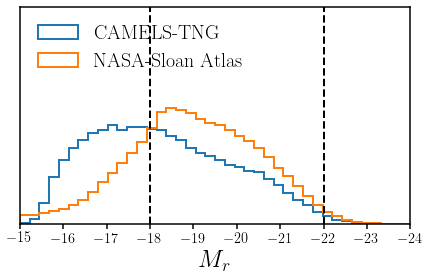

In [11]:
fig = plt.figure(figsize=(7,4))
sub = fig.add_subplot(111)
_ = sub.hist(mag_sig_train[:,1], range=(-24, -15), bins=40, density=True, 
             histtype='step', linewidth=2, label='CAMELS-TNG')
_ = sub.hist(mag_sig[:,1], range=(-24, -15), bins=40, density=True, 
             histtype='step', linewidth=2, label='NASA-Sloan Atlas')
sub.axvline(-18, color='k', linestyle='--', linewidth=2)
sub.axvline(-22, color='k', linestyle='--', linewidth=2)

sub.legend(loc='upper left', fontsize=20)
sub.set_xlabel(r'$M_r$', fontsize=25)
sub.set_xlim(-15, -24)
sub.set_ylim(0, 0.5)
sub.set_yticks([])

In [12]:
mr_lim = (mag_sig[:,1] < -18) & (mag_sig[:,1] > -22)
print(np.sum(sig_cuts & mr_lim))

70858


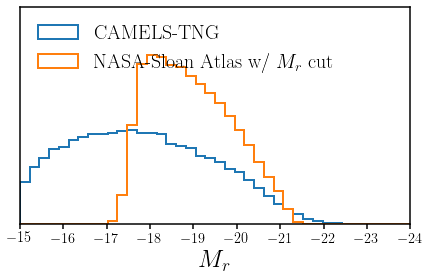

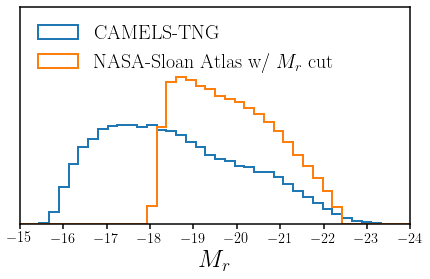

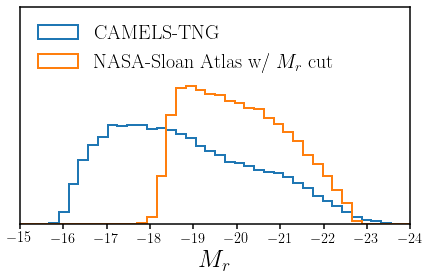

In [13]:
for i in [0, 2, 3]: 
    fig = plt.figure(figsize=(7,4))
    sub = fig.add_subplot(111)
    _ = sub.hist(mag_sig_train[:,i], range=(-24, -15), bins=40, density=True, 
                 histtype='step', linewidth=2, label='CAMELS-TNG')
    _ = sub.hist(mag_sig[:,i][mr_lim], range=(-24, -15), bins=40, density=True, 
                 histtype='step', linewidth=2, label='NASA-Sloan Atlas w/ $M_r$ cut')
    #sub.axvline(-18, color='k', linestyle='--', linewidth=2)
    #sub.axvline(-22, color='k', linestyle='--', linewidth=2)

    sub.legend(loc='upper left', fontsize=20)
    sub.set_xlabel(r'$M_r$', fontsize=25)
    sub.set_xlim(-15, -24)
    sub.set_ylim(0, 0.5)
    sub.set_yticks([])
    plt.show()

# color cuts
Determined based on the support of the CAMELS dataset

In [14]:
colors_nsa, colors_camels, lbls = [], [], []
for i in range(4): 
    for j in range(4): 
        if i < j: 
            colors_nsa.append(mag_sig[:,i] - mag_sig[:,j])
            colors_camels.append(mag_sig_train[:,i] - mag_sig_train[:,j])
            lbls.append(r'$%s - %s$' % (['g', 'r', 'i', 'z'][i], ['g', 'r', 'i', 'z'][j]))
colors_nsa = np.array(colors_nsa).T
colors_camels = np.array(colors_camels).T

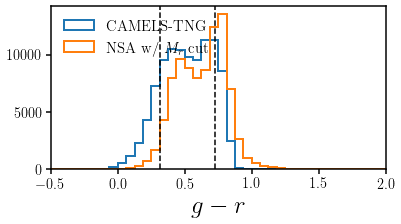

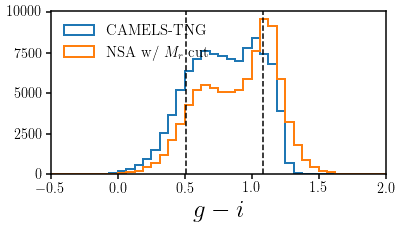

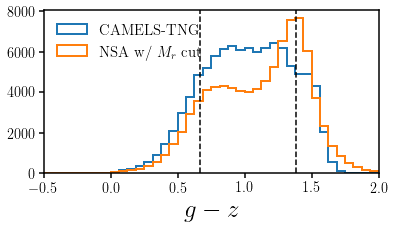

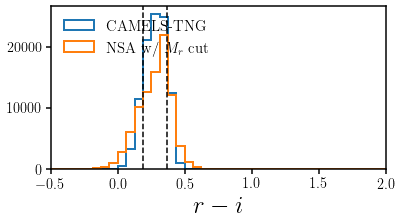

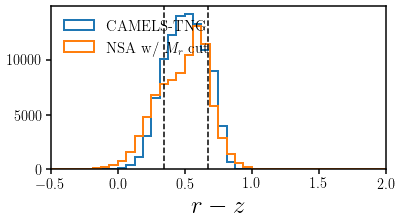

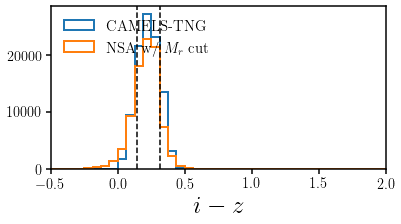

In [15]:
for col1, col2, lbl in zip(colors_nsa.T, colors_camels.T, lbls):
    fig = plt.figure(figsize=(6,3))
    sub = fig.add_subplot(111)
    _ = sub.hist(col2, range=(-0.5, 2), bins=40, histtype='step', color='C0', linewidth=2, 
                 label='CAMELS-TNG')
    _ = sub.hist(col1[mr_lim], range=(-0.5, 2.), bins=40, histtype='step', color='C1', linewidth=2, 
                 label='NSA w/ $M_r$ cut')
    sub.axvline(np.quantile(col2, (0.16)), color='k', linestyle='--')
    sub.axvline(np.quantile(col2, (0.84)), color='k', linestyle='--')            
    sub.set_xlabel(lbl, fontsize=25)
    sub.set_xlim(-0.5, 2.)
    sub.legend(loc='upper left', fontsize=15)
    plt.show()

In [17]:
for col1, col2, lbl in zip(colors_nsa.T, colors_camels.T, lbls):
    lims = np.quantile(col2, (0.16, 0.84))#(0.1, 0.9))
    print(lbl, lims)

$g - r$ [0.31321754 0.72248567]
$g - i$ [0.51003343 1.08569268]
$g - z$ [0.67007507 1.38540175]
$r - i$ [0.1896549  0.36778315]
$r - z$ [0.34452558 0.67330643]
$i - z$ [0.14157459 0.31556476]


In [23]:
color_cut = np.ones(mag_sig.shape[0]).astype(bool)
for col1, lim0, lim1 in zip(colors_nsa.T, [0.313, 0.510, 0.670, 0.190, 0.345, 0.142], [0.722, 1.086, 1.385, 0.368, 0.673, 0.316]):
    color_cut = color_cut & (col1 > lim0) & (col1 < lim1)
    
print('total galaxies ')
print(np.sum(sig_cuts & mr_lim & color_cut))

total galaxies 
22338


# compare sample with full NSA

In [24]:
from goleta import data as Data

In [25]:
Xs = Data.get_obs(cut='v1')

22338 observed galaxies


/home/chhahn/projects/goleta/src/goleta/data.py:149: RuntimeWarning: divide by zero encountered in power
  sigmag_nsa = ivar_absmag_nsa**-0.5


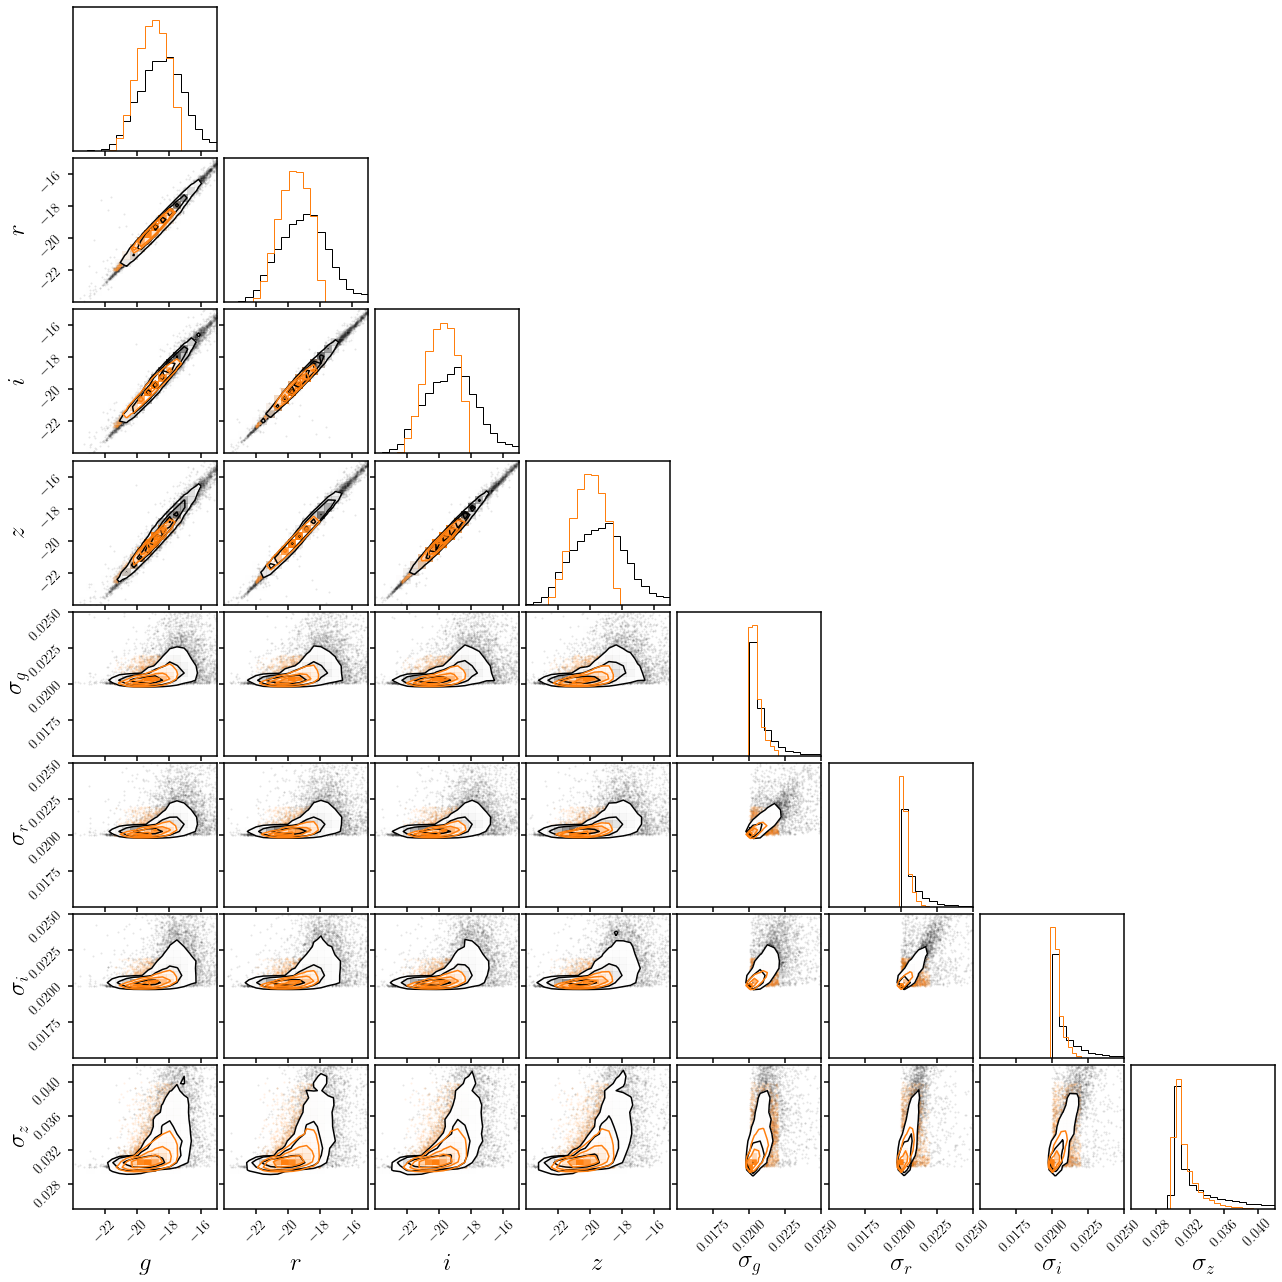

In [27]:
fig = DFM.corner(mag_sig[::10], color='k', hist_kwargs={'density': True},
               range=[(-24, -15), (-24, -15), (-24, -15), (-24, -15),
                      (0.015, 0.025), (0.015, 0.025), (0.015, 0.025), (0.025, 0.042)],
               labels=[r'$%s$' % b for b in ['g', 'r', 'i', 'z']] + [r'$\sigma_g$', r'$\sigma_r$', r'$\sigma_i$', r'$\sigma_z$'],
               label_kwargs={'fontsize': 25})
_ = DFM.corner(Xs, color='C1', hist_kwargs={'density': True},
               range=[(-24, -15), (-24, -15), (-24, -15), (-24, -15),
                      (0.019, 0.025), (0.019, 0.025), (0.019, 0.025), (0.029, 0.042)],
               labels=[r'$%s$' % b for b in ['g', 'r', 'i', 'z']] + [r'$\sigma_g$', r'$\sigma_r$', r'$\sigma_i$', r'$\sigma_z$'],
               label_kwargs={'fontsize': 25}, fig=fig)


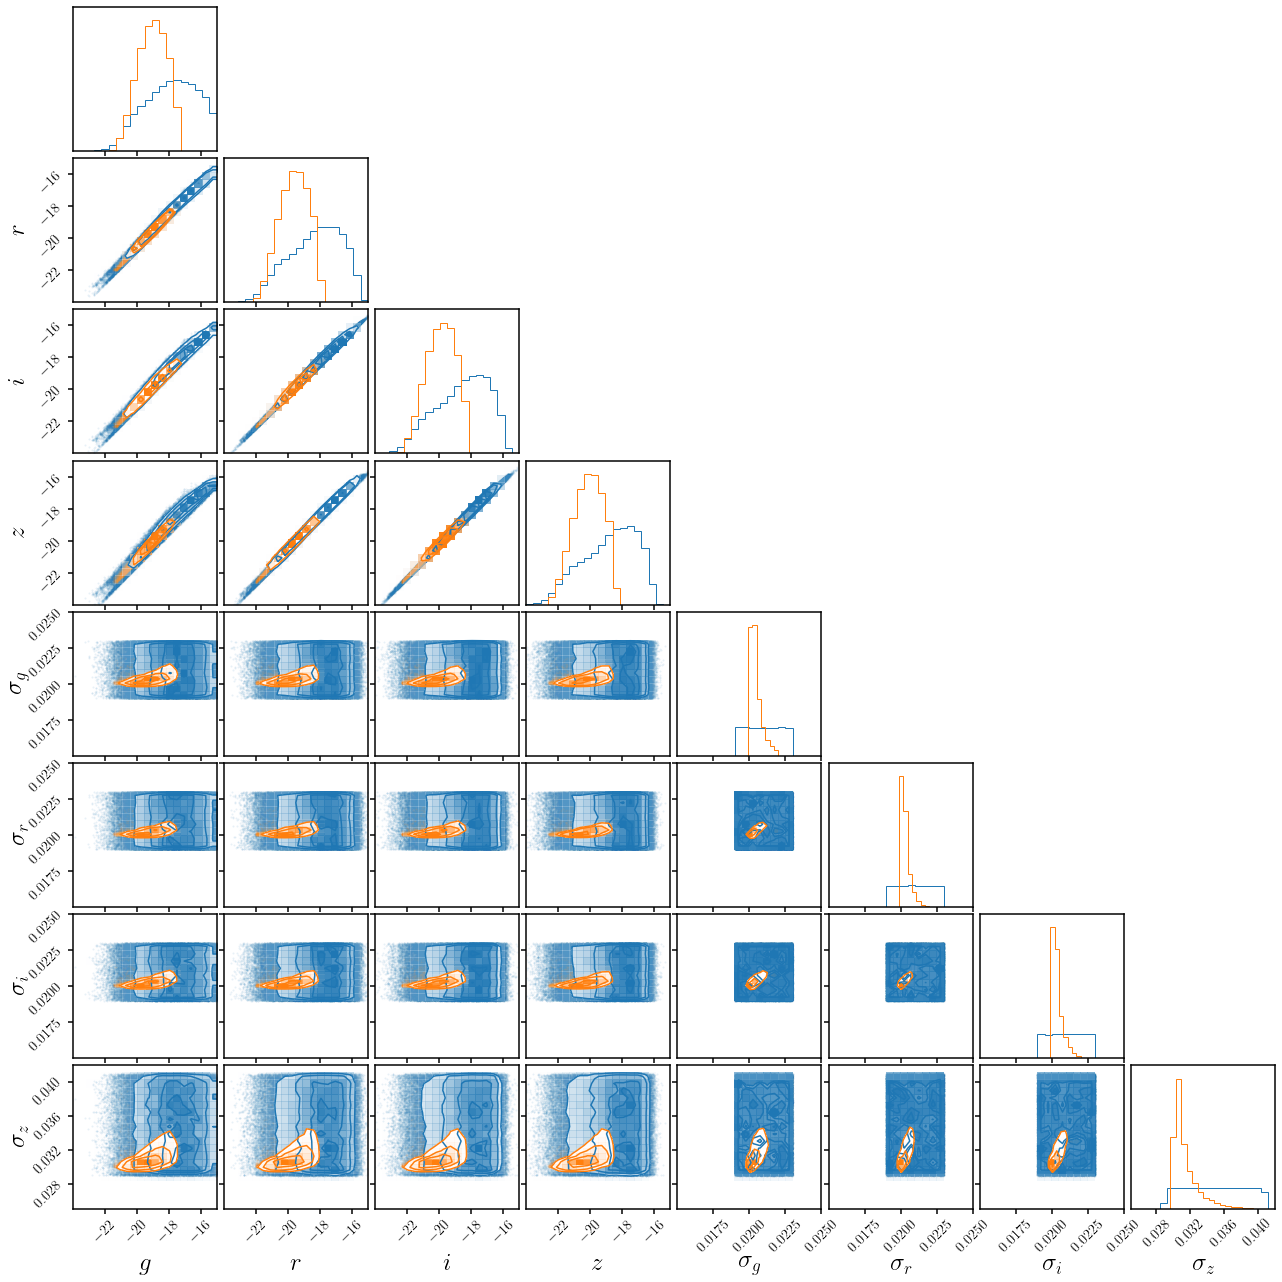

In [30]:
fig = DFM.corner(mag_sig_train, color='C0', hist_kwargs={'density': True},
               range=[(-24, -15), (-24, -15), (-24, -15), (-24, -15),
                      (0.015, 0.025), (0.015, 0.025), (0.015, 0.025), (0.025, 0.042)],
               labels=[r'$%s$' % b for b in ['g', 'r', 'i', 'z']] + [r'$\sigma_g$', r'$\sigma_r$', r'$\sigma_i$', r'$\sigma_z$'],
               label_kwargs={'fontsize': 25})
_ = DFM.corner(Xs, color='C1', hist_kwargs={'density': True},
               range=[(-24, -15), (-24, -15), (-24, -15), (-24, -15),
                      (0.019, 0.025), (0.019, 0.025), (0.019, 0.025), (0.029, 0.042)],
               labels=[r'$%s$' % b for b in ['g', 'r', 'i', 'z']] + [r'$\sigma_g$', r'$\sigma_r$', r'$\sigma_i$', r'$\sigma_z$'],
               label_kwargs={'fontsize': 25}, fig=fig)
